# Data Visualization Notebook - CLMP Detector

## Objectives

- Answer business requirement no.1:
  - The client aims to conduct a study to visually distinguish between a healthy cherry leaf from one affected by powdery mildew.

## Inputs

Images are taken from the test, train, validation folders and their subfolders. 
```bash
. 
├── inputs 
│   └──cherryleaves_dataset 
│      └──cherry-leaves                                     
│           ├── test
│           │   ├── healthy
│           │   └── powdery_mildew                   
│           ├── train
│           │   ├── healthy
│           │   └── powdery_mildew          
│           └── validation
│               ├── healthy
│               └── powdery_mildew                 
└── ...
```

## Outputs

- Determine the average image size from the training set.
- Save image shape embeddings as a pickle file.
- Create a plot showing the average and variability of images for each label.
- Visualize a plot to highlight the contrast between healthy and mildew-infected cherry leaves.
- Write code that addresses the first business requirement and can generate an image montage for the Streamlit dashboard.

## Comments | Insights

The following steps are essential for better understanding and preparing the data that will be used in the Convolutional Neural Network (CNN). Additionally, the data is visually organized to meet the client’s specifications, as outlined in Business Requirement #1.

---

## Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import joblib
sns.set_style('white')
from matplotlib.image import imread

## Set working directory

In [2]:
cwd= os.getcwd()

In [4]:
os.chdir('/workspace/CLMP-Detector/')
print("You set a new current directory")

You set a new current directory


In [5]:
work_dir = os.getcwd()
work_dir

'/workspace/CLMP-Detector'

## Set input directories

In [6]:
# Define input paths for training, validation, and testing datasets

data_directory = 'inputs/cherryleaves_dataset/cherry-leaves'
train_dir = data_directory + '/train'
validation_dir = data_directory + '/validation'
test_dir = data_directory + '/test'

## Set output directory

In [7]:
# Set the output directory for saving model results and Create a new version if necessary.

version = 'v1'
file_path = os.path.join('outputs', version)

if os.path.exists(os.path.join(work_dir, 'outputs')) and os.path.exists(file_path):
    print('Old version is already available, create a new version.')
else:
    os.makedirs(file_path)

## Set label names

In [8]:
# Get the list of labels from the train directory

labels = os.listdir(train_dir)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


---

# Data visualization of image data

---

## Compute Average Image Size for the Training Set

In Image Processing, it's beneficial to normalize image pixel values based on the dataset's mean and standard deviation. This ensures consistent model performance when applied to new images and is essential for transfer learning. However, calculating these statistics can be challenging because the entire dataset typically cannot be loaded into memory at once. Instead, it is necessary to process the dataset in batches to compute the required statistics.

**This answers Business Requirement #1**

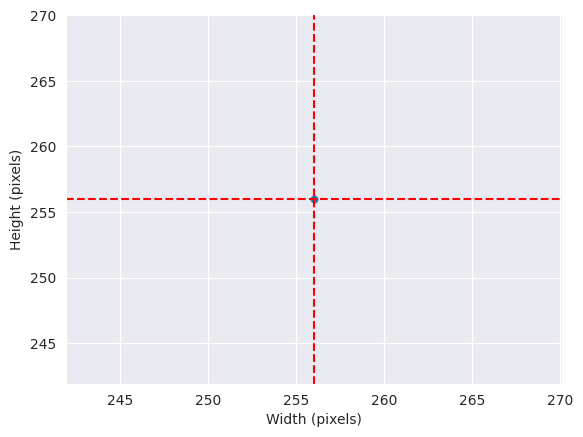

Width average: 256 
Height average: 256


In [9]:
# Calculate the average image dimensions (height and width) for the training set
# Read each image from the training directory and store its dimensions
# Plot a scatter plot of image dimensions and highlight the mean values with red dashed lines

image_height, image_width = [], []
for label in labels:
    for image_filename in os.listdir(train_dir + '/' + label):
        img = imread(train_dir + '/' + label + '/' + image_filename)
        height, width, colors = img.shape
        image_height.append(height)  # image height
        image_width.append(width)  # image width

sns.set_style("darkgrid")
fig, axes = plt.subplots()
sns.scatterplot(x=image_width, y=image_height, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
image_height_mean = int(np.array(image_height).mean())
image_width_mean = int(np.array(image_width).mean())
axes.axvline(x=image_height_mean, color='r', linestyle='--')
axes.axhline(y=image_width_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {image_width_mean} \nHeight average: {image_height_mean}")

### Define the image shape tuple based on the computed average height, width, and 3 color channels (RGB)


In [10]:
image_shape = (image_height_mean, image_width_mean, 3)
image_shape

(256, 256, 3)

### Save the computed image shape as a pickle file to the specified output directory


In [11]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

---

## Average and variability of images per label

### Load images in an array (tensor)

In [12]:
from tensorflow.keras.preprocessing import image


def load_image_as_array(data_directory, new_size=(50, 50), n_images_per_label=20):

    """
    Load images from a directory, resize them, and return them as arrays.
    
    Parameters:
    - data_directory: str
        Path to the directory containing labeled subfolders of images.
    - new_size: tuple, default (50, 50)
        The target size for resizing each image (height, width).
    - n_images_per_label: int, default 20
        The number of images to load per label to avoid excessive loading time.
        
    Returns:
    - X: numpy array
        Array of resized image data with shape (n_samples, height, width, channels).
    - y: numpy array
        Array of corresponding image labels.
    """

    X, y = np.array([], dtype='int'), np.array([], dtype='object') # Initialize empty arrays for data and labels
    labels = os.listdir(data_directory)  # Get the list of labels from the directory

    for label in labels:
        counter = 0
        for image_filename in os.listdir(data_directory + '/' + label):
            # Limit the number of images per label to avoid long processing times
            if counter < n_images_per_label:

                # Load image and resize it to the specified size
                img = image.load_img(
                    data_directory + '/' + label + '/' + image_filename, target_size=new_size)
                
                # Normalize the pixel values if needed
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                # Append the resized image and label to the respective arrays
                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    # Return the array of images and their labels
    return X, y

### Load image shapes and labels in an array

In [13]:
# Load images and labels from the training directory (train_dir), resizing to the specified image shape 
# and limiting the number of images per label to 30; then print the shapes of the resulting arrays.

X, y = load_image_as_array(data_directory=train_dir,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 256, 256, 3) (60,)


### Plot and save mean and variability of images per label

In [14]:
def plot_mean_variability_per_labels(X, y, figsize=(8, 5), save_image=False):
    """
    The pseudo-code for the function is:
    * Loop over all labels
    * Subset an array containing image data with the corresponding labels for each image
    * Calculate the mean and standard deviation
    * Create a figure displaying the mean and variability of images
    * Save_image: bool, default False. But If True, saves the plots as image files; if False, displays them.
    """

    for label_to_display in np.unique(y):
        sns.set_style("white") # Set the plot style to white

        # Reshape labels and create a mask for the current label
        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask] # Select images corresponding to the current label


        avg_img = np.mean(arr, axis=0) # Compute the average image
        std_img = np.std(arr, axis=0) # Compute the variability image
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        
        # Create subplots for average and variability images
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray') # Display average image
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray') # Display variability image

        # Save or show the plot based on the save_image parameter
        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout() # Adjust layout for better spacing
            plt.show()         # Display the plots
            print("\n")        # Print a newline for better readability

==== Label healthy ====
Image Shape: (256, 256, 3)
==== Label powdery_mildew ====
Image Shape: (256, 256, 3)


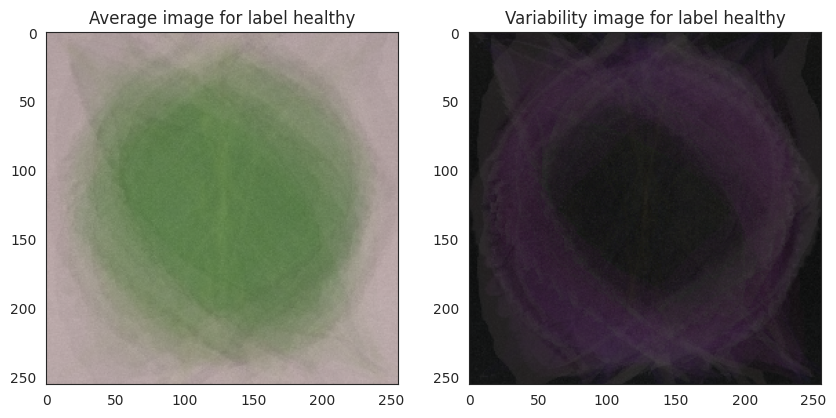

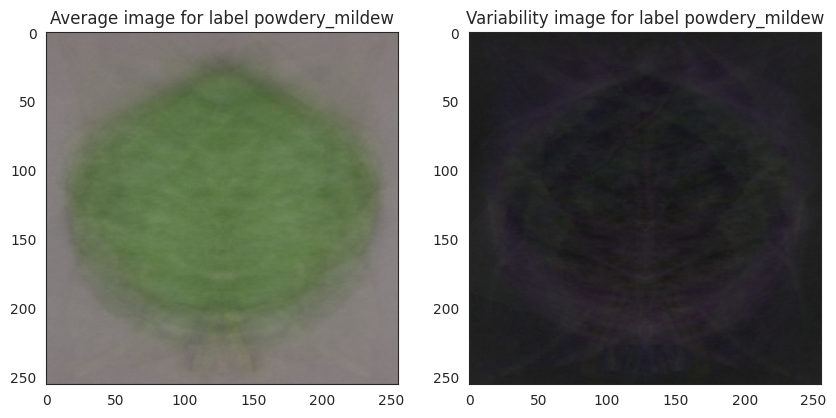

In [15]:
# Call the function (above) to plot the average image and variability for each label,
# setting the figure size to (10, 5) and saving the resulting plots as image files.

plot_mean_variability_per_labels(X=X, y=y, figsize=(10, 5), save_image=True)

---

## Difference between average healthy cherry leaves and average powdery-mildew infected leaves

In [16]:
# Extracts images corresponding to a specific label from the dataset.

def subset_image_label(X, y, label_to_display):
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    df = X[boolean_mask]
    return df


# Compare the average images of two labels and plot their difference.

def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False):
    """
    Checks if the labels exist in the set of unique labels
    Calculates the mean and difference for label1 and label2
    Plots a chart and if True, saves the plot as an image file; if False, displays it.
    """
    sns.set_style("white") # Set the plot style to white

    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(
            f"Either label {label} or label {label_2}, are not in {np.unique(y)} ")
        return

    # Calculate the mean image for label_1
    images_label = subset_image_label(X, y, label_1)
    label1_avg = np.mean(images_label, axis=0)

    # Calculate the mean image for label_2
    images_label = subset_image_label(X, y, label_2)
    label2_avg = np.mean(images_label, axis=0)

    # Calculate the difference between the average images and plot them
    difference_mean = label1_avg - label2_avg
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average Image for {label_1}')
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average Image for {label_2}')
    axes[2].imshow(difference_mean, cmap='gray')
    axes[2].set_title(f'Difference Between Average Images: {label_1} - {label_2}')
    
    # Save or show the plot based on the save_image parameter
    if save_image:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()  # Adjust layout for better spacing
        plt.show()          # Display the plots

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


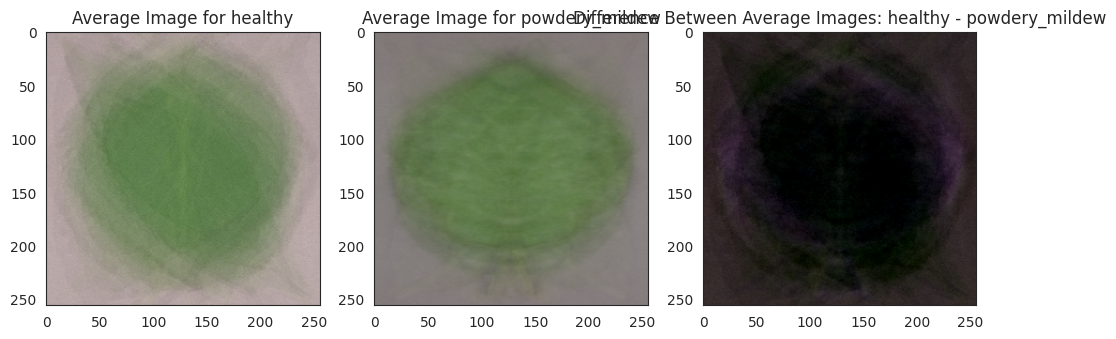

In [17]:
# Call the function to compare the average images of healthy and powdery mildew-infected leaves,
# plotting their difference with a figure size of (12, 10) and saving the resulting plot as an image file.

diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='healthy', label_2='powdery_mildew',
                                        figsize=(12, 10),
                                        save_image=True
                                        )

---

## Image Montage

In [18]:
import itertools
import random
sns.set_style("white")


def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15, 10)):
    """
    if the label exists in the directory
    check if your montage space is greater than the subset size
    create a list of axes indices based on nrows and ncols
    create a Figure and display images
    in this loop, load and plot the given image
    """

    labels = os.listdir(dir_path) # List all available labels in the directory

    # Check if the specified label exists in the directory
    if label_to_display in labels:

        # Get the list of images for the specified label
        images_list = os.listdir(dir_path + '/' + label_to_display)
        
        # Ensure the montage space is sufficient for the number of images requested
        if nrows * ncols < len(images_list):
            img_idx = random.sample(images_list, nrows * ncols)
        else:
            print(
                f"Please decrease the number of rows or columns to fit your montage. \n"
                f"You have {len(images_list)} images available, but you requested a montage with {nrows * ncols} slots."
            )
            return

        # Generate a list of axes indices based on the specified number of rows and columns
        list_rows = range(0, nrows)
        list_cols = range(0, ncols)
        plot_idx = list(itertools.product(list_rows, list_cols))

        # create a Figure and display images
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        
        # Loop through the selected images to load and display them
        for x in range(0, nrows*ncols):
            img = imread(dir_path + '/' + label_to_display + '/' + img_idx[x])
            img_shape = img.shape
            axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
            axes[plot_idx[x][0], plot_idx[x][1]].set_title(
                f"Width {img_shape[1]}px x Height {img_shape[0]}px")
            axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
            axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])

        plt.tight_layout()  # Adjust layout to prevent overlap
        plt.show()          # Display the montage

    else:
        # Print a message if the specified label does not exist
        print("The selected label does not exist in the directory.")
        print(f"Available labels are: {', '.join(labels)}")    # Show available labels

### Run Montage in all labels

healthy


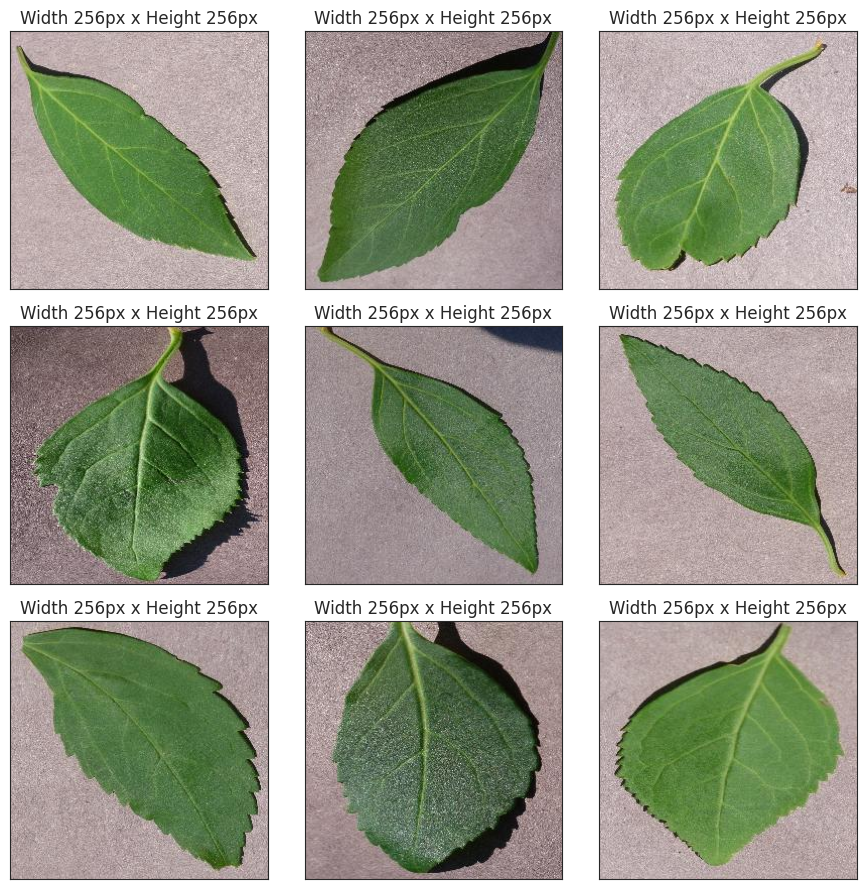



powdery_mildew


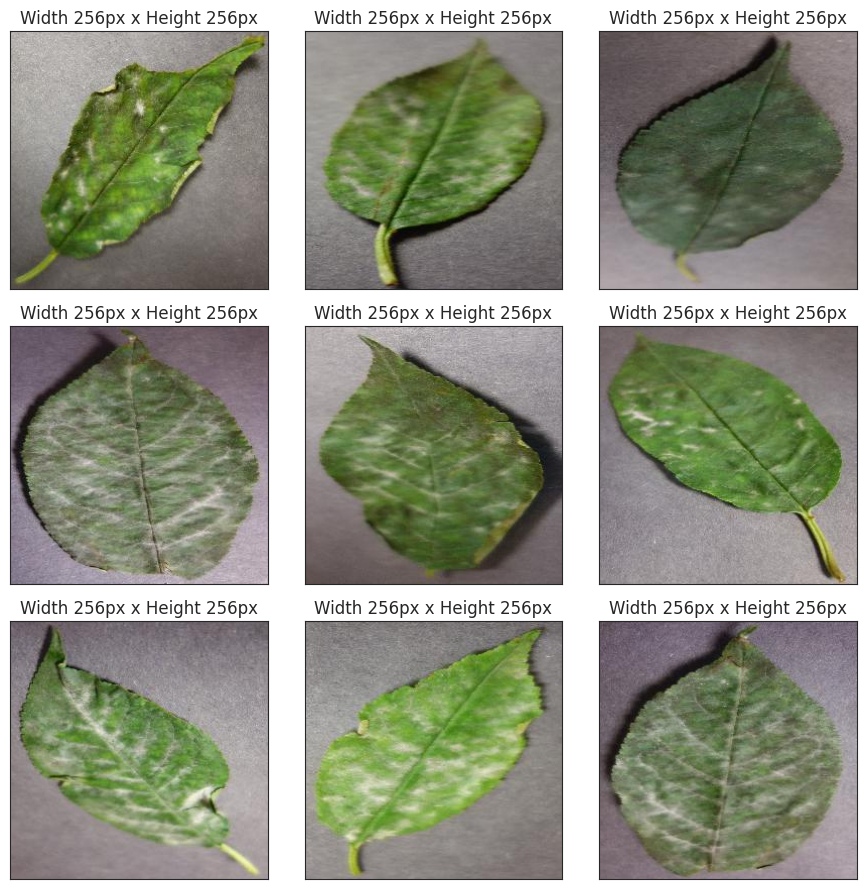

In [19]:
# Loop through each label in the directory
for label in labels:
    print(label)    # Print the current label being processed

    # Create and display an image montage for the current label,
    # arranging images in a 3x3 grid with a figure size of (9, 9).
    image_montage(dir_path=validation_dir,
                  label_to_display=label,
                  nrows=3, ncols=3,
                  figsize=(9, 9)
                  )
    print("\n")    # Print a newline for better separation between montages

## Conclusion and Next Steps
The analysis reveals the following insights:

- Healthy cherry leaves are generally brighter with a more uniform texture, showcasing distinct leaf veins and finer details.

- Unhealthy cherry leaves infected with powdery mildew appear darker and exhibit a more irregular texture. The details on these leaves are less pronounced, and the texture often remains consistent across the infected areas.

Next, we'll proceed with the Modelling and Evaluation Jupyter Notebook to build and assess the predictive model.